In [81]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lmfit import Model
import matplotlib.ticker as ticker

In [82]:
# Functions

def line(x, m, b):
    return x * m + b

def tlm(s, r_s, N, w, L, r_c):
    return ((r_s * s) / (2 * N * (w + L + s) - L - s)) + (2 * r_c)

def tlm2(s, r_s, N, w, L, l_t):
    return (r_s / (2 * N * (w + L + s) - L - s)) * (s + 2 * l_t)

def w_contact(s, N, w, L):
    return (2 * N * (w + L + s)) - L - s

In [83]:
# Models

line_mod = Model(line)
line_params = line_mod.make_params(m = 1, b = 1)

# Considering L_t to get \rho_c Contact Resistivity
tlm_mod2 = Model(tlm2)
tlm2_params = tlm_mod2.make_params()
tlm2_params['r_s'].set(value = 1e6)
tlm2_params['N'].set(value = 60, vary = False)
tlm2_params['w'].set(value = 5e-4, vary = False)
tlm2_params['L'].set(value = 3200e-4, vary = False)
tlm2_params['l_t'].set(value = 1e-5, min = 0)

In [84]:
# Settings

col = ['Potential (V)', 'Current (A)', 'Time (s)']
col2 = ['Structure', 'Spacing (cm)', 'Resistance ($\Omega$)']
idea2 = {'P01': 2e-4,
         'P02': 5e-4,
         'P03': 10e-4,
         'P04' : 20e-4
         }

formatter = ticker.FuncFormatter(lambda x, pos: "{:.1f}".format(x / 1e6))
formatter_1 = ticker.FuncFormatter(lambda x, pos: "{:.1f}".format(x * 1e4))
formatter_2 = ticker.FuncFormatter(lambda x, pos: "{:.1f}".format(x * 1e6))

palette = 'viridis'

In [85]:
# Function to process data

def C_R(path, thickness, sample):
    
    files = [os.path.join(path, i) for i in os.listdir(path)]
    iv_val = pd.DataFrame(columns = col2)
    iv_df = pd.DataFrame()
    n = 0
    for i in files:
        directory, filename = os.path.split(i)
        df = pd.read_csv(i, sep = ';', skiprows = 1, names = col)
        df['Device'] = filename[:-4]
        df['dI/dV'] = np.gradient(df[col[1]], df[col[0]])
        
        for structure in idea2.keys():
            if structure in filename:
                df['Spacing ($\mu$m)'] = idea2[structure] *1e4
        
        line_fit = line_mod.fit(df[col[1]], line_params, x = df[col[0]])
        slope = line_fit.values['m']
        resistance = 1 / slope
        
        for j in idea2.keys():
            if j in filename:
                iv_val.loc[n] = (j, idea2[j], resistance)
                
        df['Norm dI/dV'] = df['dI/dV'] / slope
        iv_df = pd.concat([iv_df, df], ignore_index = True)
        
        n += 1
    iv_df['Sample'] = sample
    iv_val['Sample'] = sample
    # print(iv_df)

    width_ = (w_contact(iv_val[col2[1]], 60, 5e-4, 3200e-4))
    width_avg = width_.mean()

    all_avg = pd.DataFrame()
    u_s = iv_val.Structure.unique()
    df_dict = {i : pd.DataFrame() for i in u_s}
    
    for key in df_dict.keys():
        df_dict[key] = iv_val[:][iv_val.Structure == key]
        
    for key, df in df_dict.items():
        mean_ = df.mean(numeric_only = True).reset_index().transpose()
        mean_.columns = mean_.iloc[0]
        mean_ = mean_[1:].reset_index(drop=True)
        all_avg = pd.concat([all_avg, mean_], ignore_index = True)
    
    
    tlm_fit2 = tlm_mod2.fit(all_avg[col2[2]], tlm2_params, s = all_avg[col2[1]])   
    # using the average for the fit. Same values, lower numerical error 
    # tlm_fit2 = tlm_mod2.fit(iv_val[col2[2]], tlm2_params, s = iv_val[col2[1]])
    
    # print(tlm_fit2.fit_report())
    rc = tlm_mod2.eval(tlm_fit2.params, s = 0) / 2
    lt = tlm_fit2.values['l_t']
    p_c = rc * lt * width_avg #Contact resistiviy ohm * cm^2
    # sigma = (1 / tlm_fit2.values['r_s'] ) / (thickness * 1e-7 * width_avg)
    sigma = 1 / (tlm_fit2.values['r_s'] * thickness * 1e-7)
    r_s = tlm_fit2.values['r_s']

    print('Contact Resistivity = ' + str(p_c) + ' Ohm cm2')
    print('LMO conductivity = ' + str(sigma) + ' S/cm')
    
    
    # Plot
    fig, ax = plt.subplots(1, 2, figsize = (15,5), dpi = 200) #    1, 2, figsize = (15,5),
    
    cross_zero = np.array([-1, 0, 20]) * 1e-4
    y_zero = tlm_mod2.eval(tlm_fit2.params, s = cross_zero)
    
    sns.lineplot(data = iv_val, x = col2[1], y = col2[2], marker='o', markersize = 8, errorbar='sd',err_style='bars', linestyle='')
    sns.lineplot(x = cross_zero, y = y_zero)
    
    plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)  # Horizontal zero line
    plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)  # Vertical zero line
    
    ax[1].set_xlabel('Spacing ($\mu$m)')
    ax[1].set_ylabel('Resistance ($\Omega$)')
    # ax[1].yaxis.set_major_formatter(formatter)
    ax[1].xaxis.set_major_formatter(formatter_1)
    #
    sns.scatterplot(data = iv_val, x = col2[1], y = col2[2], ax = ax[0])
    
    fit_vals = {'Sheet Resistance' : r_s,
                'Contact Resistance' : rc,
                'Transfer Lenght' : lt,
                'Contact Resistivity' : p_c,
                'Conductivity' : sigma,
                'Sample' : sample}
    
    return iv_val, tlm_fit2, fit_vals, iv_df

c:\Users\lopezb41\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:1240: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
c:\Users\lopezb41\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:1242: RuntimeWarning: divide by zero encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))
c:\Users\lopezb41\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:1248: RuntimeWarning: invalid value encountered in add
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]
c:\Users\lopezb41\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:1240: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
c:\Users\lopezb41\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:1242: RuntimeWarning: divide by zero encountered in divide
  c = 

Contact Resistivity = 60040.01112760783 Ohm cm2
LMO conductivity = 1.0445985505694505e-06 S/cm


c:\Users\lopezb41\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\axes\_axes.py:1180: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
c:\Users\lopezb41\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\axes\_axes.py:1181: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


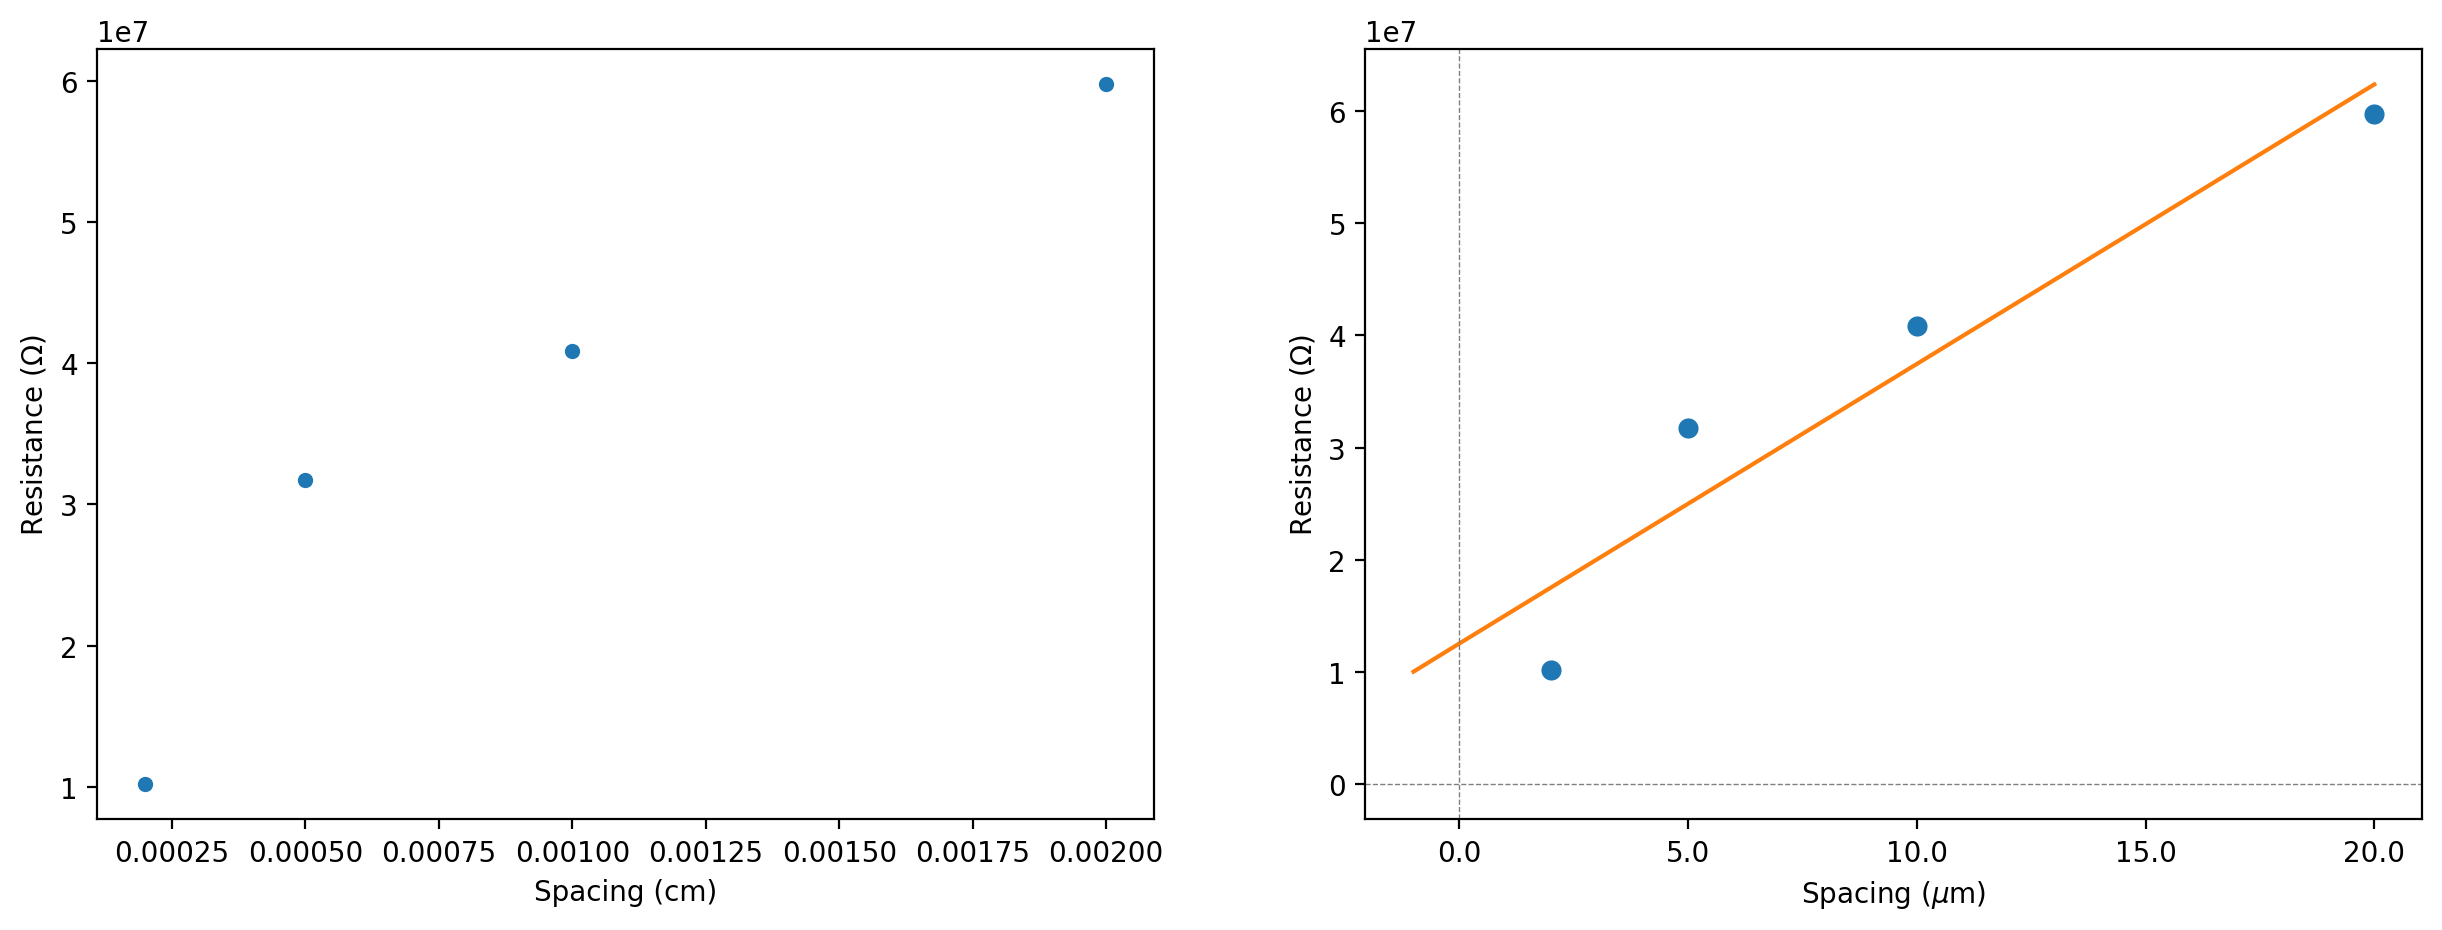

In [86]:
# PT on substate
path = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Contact Resistance\LSB_07\0G_24'
sample = 'Substrate/Pt 100nm'
substrate, substrate_fit, substrate_fit_vals, substrate_iv_curves= C_R(path, 10,  sample)
# print(substrate_fit.fit_report())



c:\Users\lopezb41\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:1240: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
c:\Users\lopezb41\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:1242: RuntimeWarning: divide by zero encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))
c:\Users\lopezb41\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:1248: RuntimeWarning: invalid value encountered in add
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]
c:\Users\lopezb41\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:1240: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
c:\Users\lopezb41\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:1242: RuntimeWarning: divide by zero encountered in divide
  c = 

Contact Resistivity = 223.39672851086019 Ohm cm2
LMO conductivity = 3.4730083119464673e-07 S/cm
[[Model]]
    Model(tlm2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 289
    # data points      = 4
    # variables        = 2
    chi-square         = 1.0654e+10
    reduced chi-square = 5.3269e+09
    Akaike info crit   = 90.8115621
    Bayesian info crit = 89.5841508
    R-squared          = 0.99991775
[[Variables]]
    r_s:  3.1993e+11 +/- 2.0455e+09 (0.64%) (init = 1000000)
    N:    60 (fixed)
    w:    0.0005 (fixed)
    L:    0.32 (fixed)
    l_t:  2.6387e-05 +/- 3.8038e-06 (14.42%) (init = 1e-05)
[[Correlations]] (unreported correlations are < 0.100)
    C(r_s, l_t) = -0.819


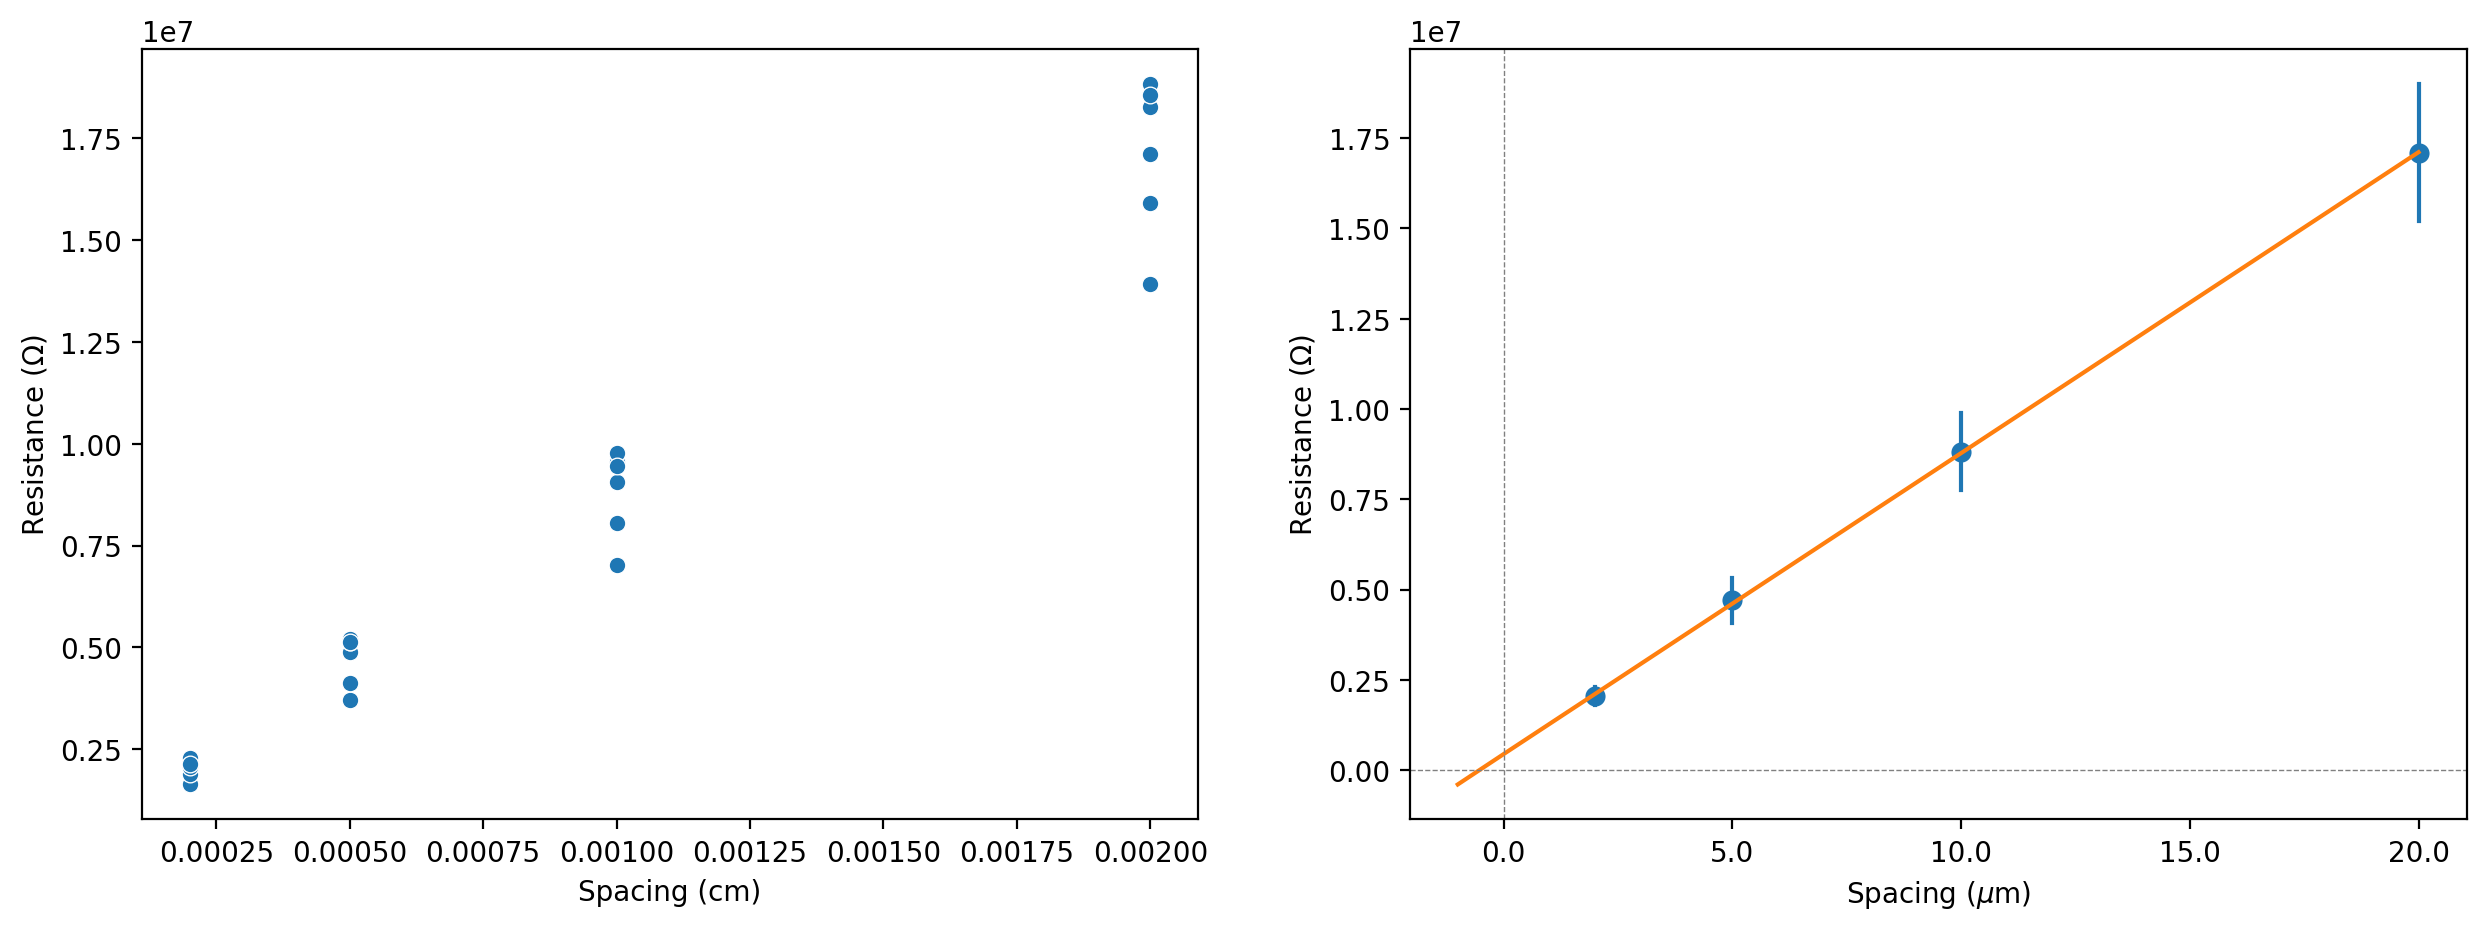

In [87]:
# TI2_01
path = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Contact Resistance\IDEA2_TLM\LMO_Pt'
sample = 'LMO 90nm/Pt 100nm'
TI2_01, TI2_01_fit, TI2_01_fit_vals, TI2_01_iv_curves= C_R(path, 90,  sample)
print(TI2_01_fit.fit_report())
# TI2_01_iv_curves

c:\Users\lopezb41\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:1240: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
c:\Users\lopezb41\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:1242: RuntimeWarning: divide by zero encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))
c:\Users\lopezb41\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:1248: RuntimeWarning: invalid value encountered in add
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]
c:\Users\lopezb41\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:1240: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
c:\Users\lopezb41\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:1242: RuntimeWarning: divide by zero encountered in divide
  c = 

Contact Resistivity = 3.637831410088925e-12 Ohm cm2
LMO conductivity = 3.195904940088184e-07 S/cm
[[Model]]
    Model(tlm2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 326
    # data points      = 4
    # variables        = 2
    chi-square         = 5.7862e+11
    reduced chi-square = 2.8931e+11
    Akaike info crit   = 106.790478
    Bayesian info crit = 105.563067
    R-squared          = 0.99655683
##  Warning: uncertainties could not be estimated:
    l_t:  at boundary
[[Variables]]
    r_s:  3.4767e+11 (init = 1000000)
    N:    60 (fixed)
    w:    0.0005 (fixed)
    L:    0.32 (fixed)
    l_t:  3.2301e-12 (init = 1e-05)


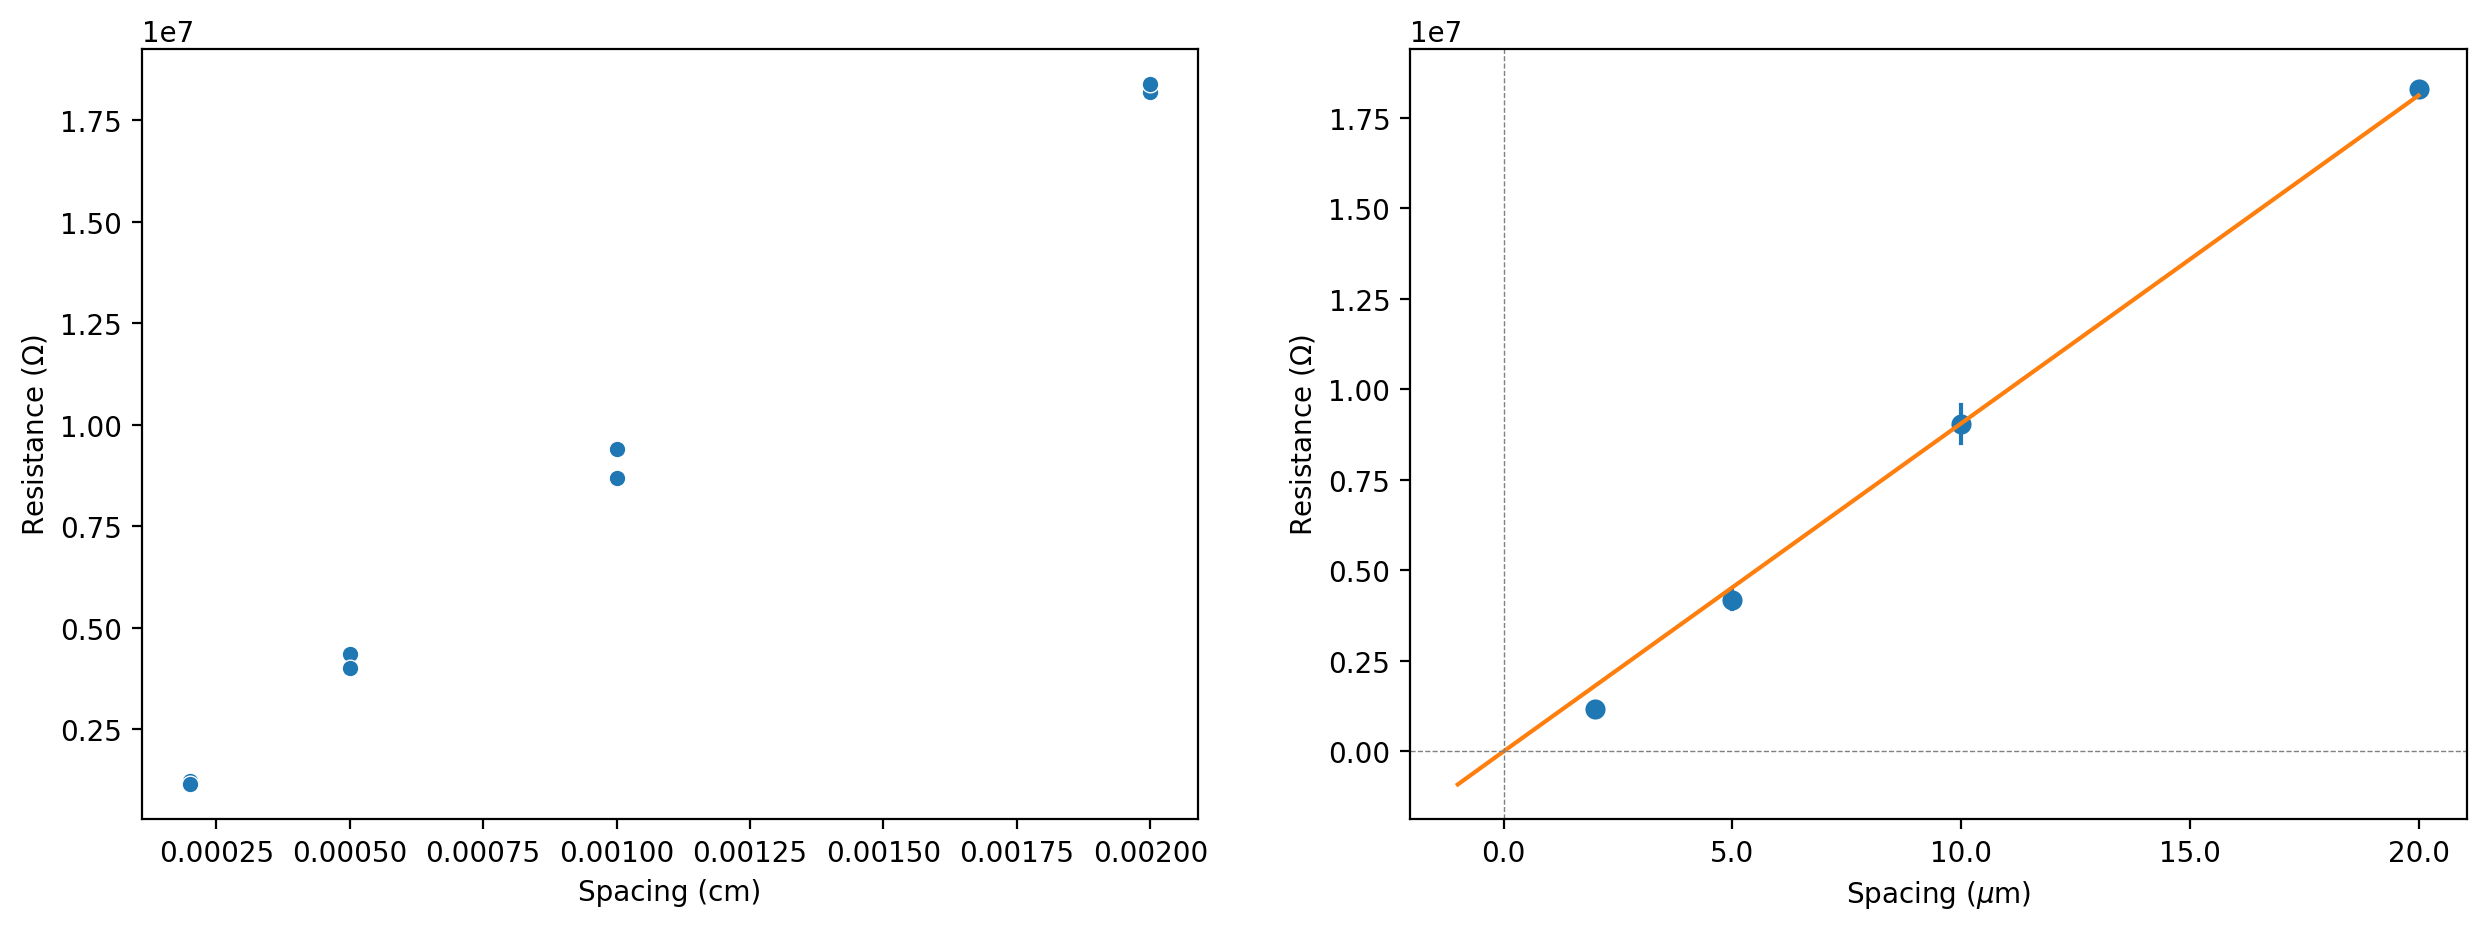

In [88]:
# LMO/Pt ext
path = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Contact Resistance\IDEA2_TLM\LMO_Pt_ext'
sample = 'LMO 90nm/Pt 100nm ext'
lmo2h_pt, lmo2h_pt_fit, lmo2h_pt_fit_vals, lmo2h_pt_iv_curves= C_R(path, 90,  sample)
print(lmo2h_pt_fit.fit_report())

c:\Users\lopezb41\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:1240: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
c:\Users\lopezb41\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:1242: RuntimeWarning: divide by zero encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))
c:\Users\lopezb41\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:1248: RuntimeWarning: invalid value encountered in add
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]
c:\Users\lopezb41\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:1240: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
c:\Users\lopezb41\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:1242: RuntimeWarning: divide by zero encountered in divide
  c = 

Contact Resistivity = 2135.9610582080472 Ohm cm2
LMO conductivity = 1.3287828816591093e-06 S/cm
[[Model]]
    Model(tlm2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 236
    # data points      = 4
    # variables        = 2
    chi-square         = 2.7833e+09
    reduced chi-square = 1.3916e+09
    Akaike info crit   = 85.4423673
    Bayesian info crit = 84.2149561
    R-squared          = 0.99968500
[[Variables]]
    r_s:  8.3619e+10 +/- 1.0455e+09 (1.25%) (init = 1000000)
    N:    60 (fixed)
    w:    0.0005 (fixed)
    L:    0.32 (fixed)
    l_t:  1.5959e-04 +/- 8.8558e-06 (5.55%) (init = 1e-05)
[[Correlations]] (unreported correlations are < 0.100)
    C(r_s, l_t) = -0.876


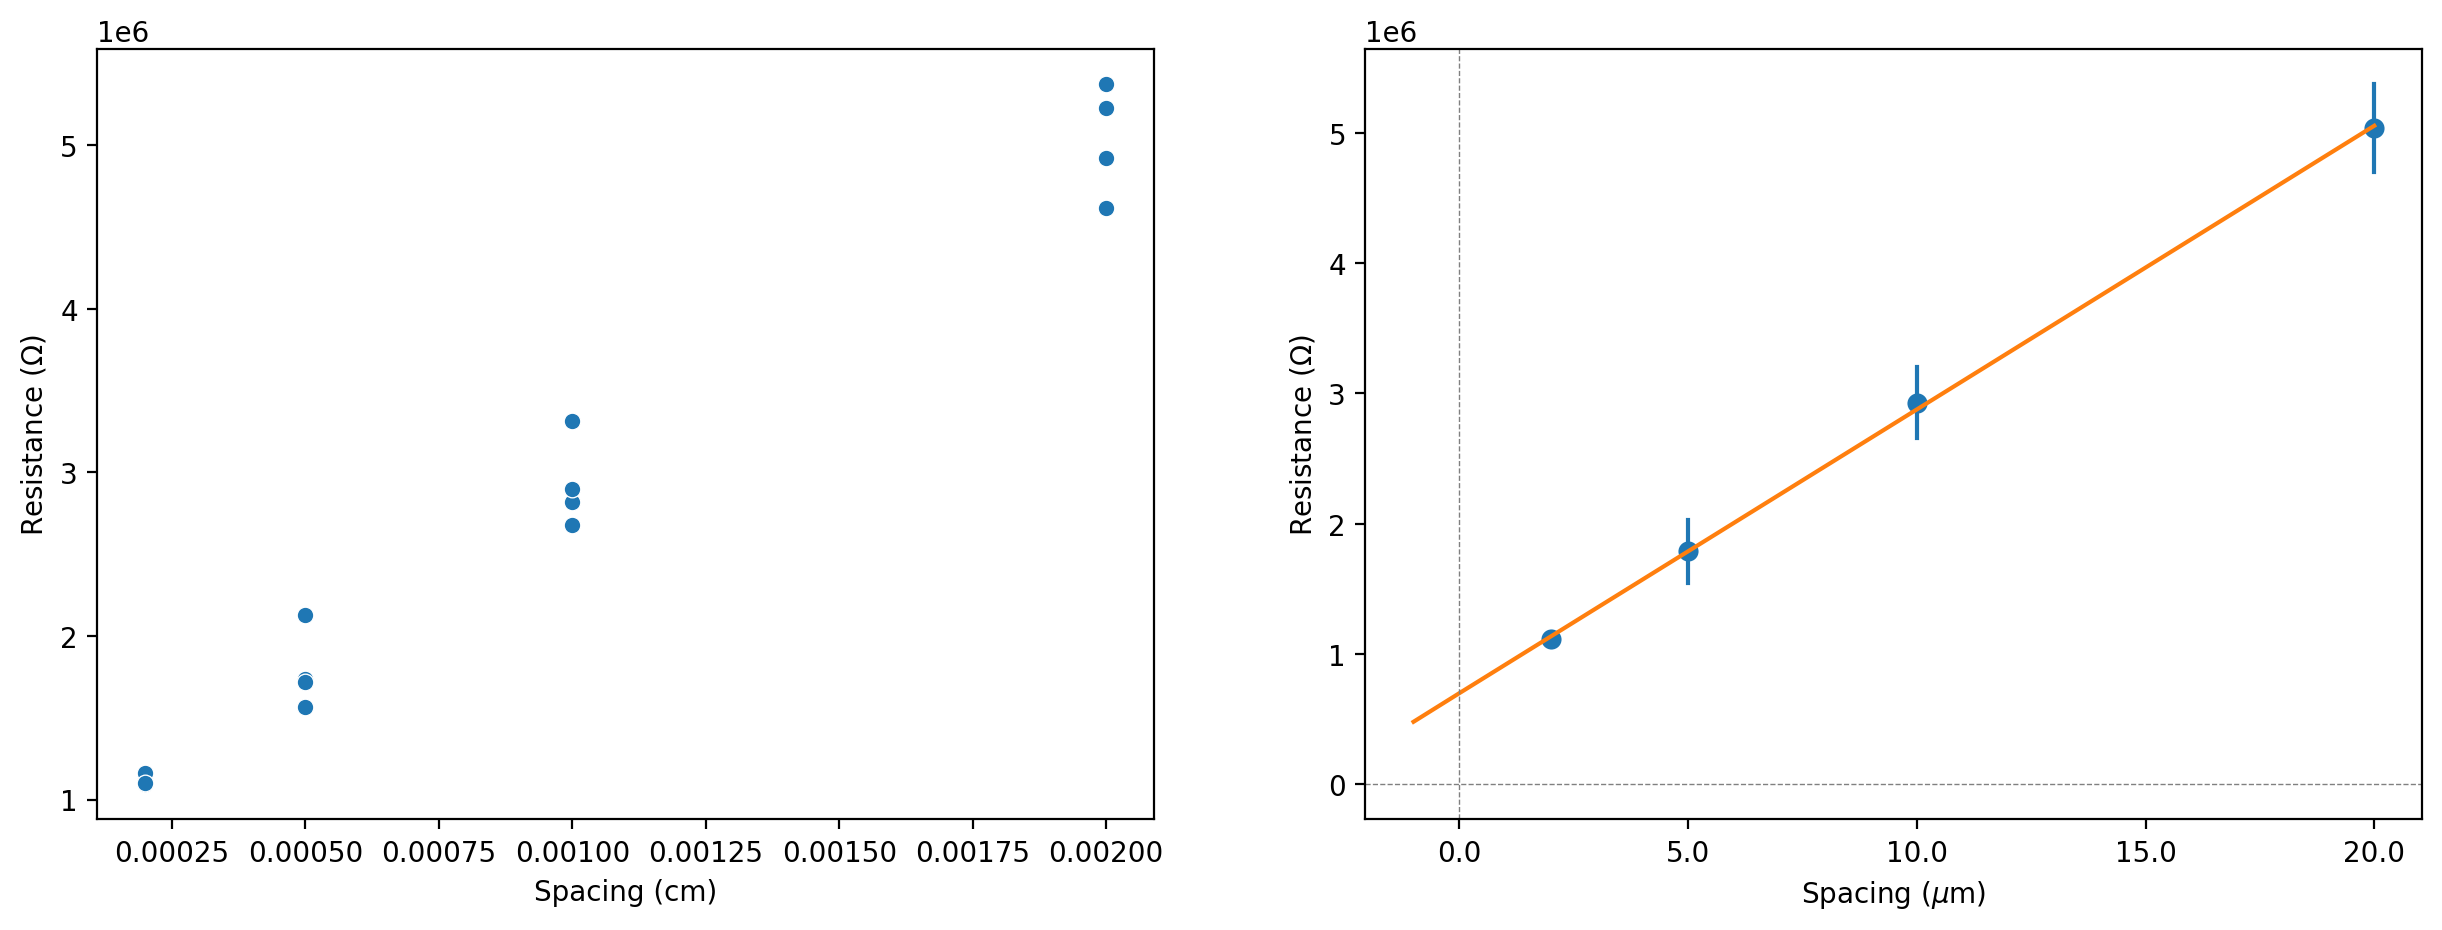

In [89]:
# LMO/C/Pt
path = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Contact Resistance\IDEA2_TLM\LMO_C_Pt'
sample = 'LMO 90nm/C 65nm/Pt 100nm'
lmo_c_pt, lmo_c_pt_fit, lmo_c_pt_fit_vals, lmo_c_pt_iv_curves = C_R(path, 90, sample)
print(lmo_c_pt_fit.fit_report())

c:\Users\lopezb41\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:1240: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
c:\Users\lopezb41\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:1242: RuntimeWarning: divide by zero encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))
c:\Users\lopezb41\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:1248: RuntimeWarning: invalid value encountered in add
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]
c:\Users\lopezb41\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:1240: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
c:\Users\lopezb41\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:1242: RuntimeWarning: divide by zero encountered in divide
  c = 

Contact Resistivity = 2585.8560488507424 Ohm cm2
LMO conductivity = 1.8563900974762355e-06 S/cm


c:\Users\lopezb41\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\axes\_axes.py:1180: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
c:\Users\lopezb41\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\axes\_axes.py:1181: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


[[Model]]
    Model(tlm2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 245
    # data points      = 4
    # variables        = 2
    chi-square         = 1.2121e+09
    reduced chi-square = 6.0604e+08
    Akaike info crit   = 82.1172143
    Bayesian info crit = 80.8898030
    R-squared          = 0.99973209
[[Variables]]
    r_s:  5.9853e+10 +/- 6.8995e+08 (1.15%) (init = 1000000)
    N:    60 (fixed)
    w:    0.0005 (fixed)
    L:    0.32 (fixed)
    l_t:  2.0755e-04 +/- 8.6530e-06 (4.17%) (init = 1e-05)
[[Correlations]] (unreported correlations are < 0.100)
    C(r_s, l_t) = -0.891


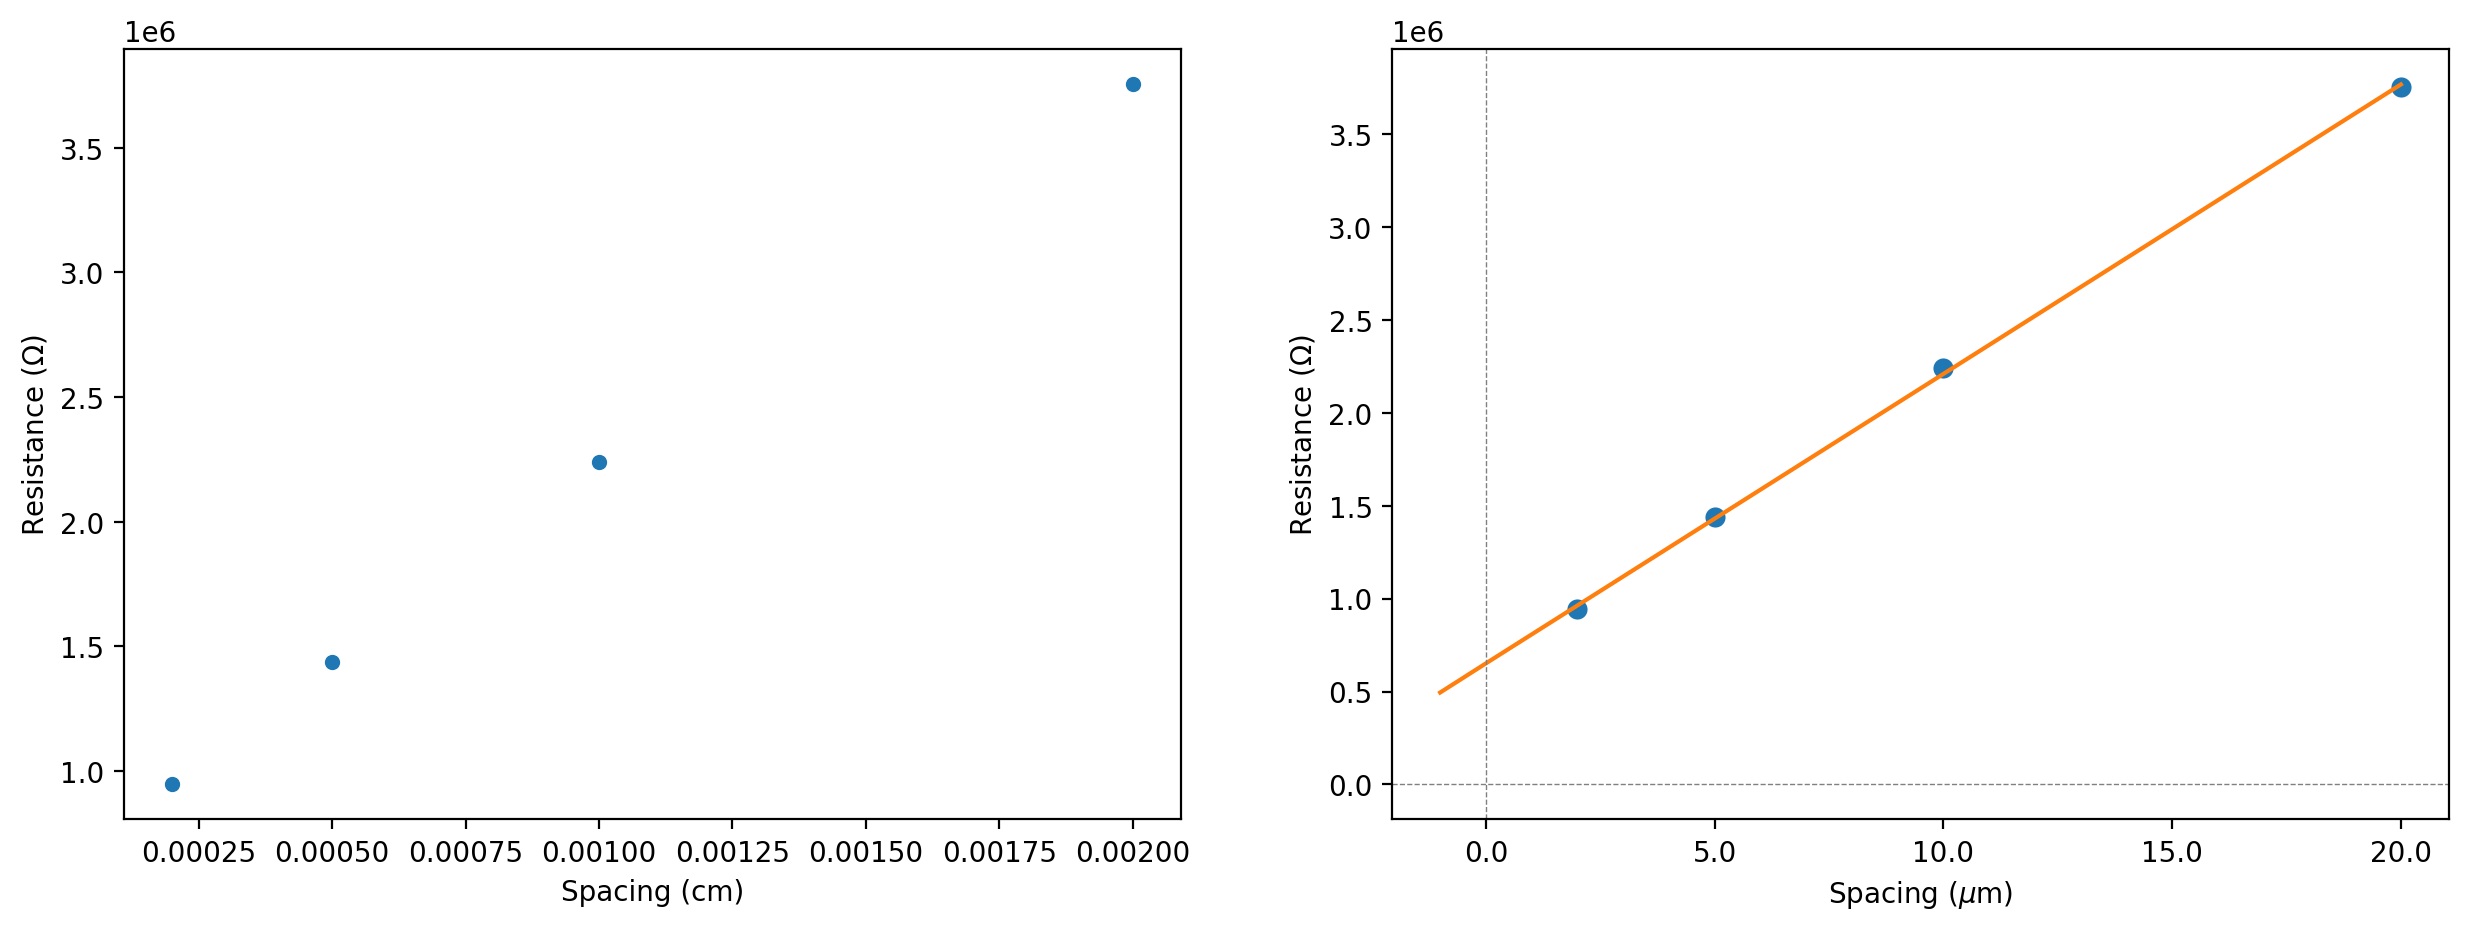

In [90]:
# LMO/C/Pt 2nd sample
path = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Contact Resistance\IDEA2_TLM\LMO_C_Pt2'
sample = 'LMO 90nm/C 65nm/Pt 100nm'
lmo_c_pt2, lmo_c_pt_fit2, lmo_c_pt_fit_vals2, lmo_c_pt_iv_curves2 = C_R(path, 90, sample)
print(lmo_c_pt_fit2.fit_report())

c:\Users\lopezb41\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:1240: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
c:\Users\lopezb41\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:1242: RuntimeWarning: divide by zero encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))
c:\Users\lopezb41\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:1248: RuntimeWarning: invalid value encountered in add
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]
c:\Users\lopezb41\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:1240: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
c:\Users\lopezb41\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:1242: RuntimeWarning: divide by zero encountered in divide
  c = 

Contact Resistivity = 404.64342182765785 Ohm cm2
LMO conductivity = 1.8233288692953587e-06 S/cm
[[Model]]
    Model(tlm2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 210
    # data points      = 4
    # variables        = 2
    chi-square         = 1.3596e+09
    reduced chi-square = 6.7980e+08
    Akaike info crit   = 82.5766459
    Bayesian info crit = 81.3492346
    R-squared          = 0.99971055
[[Variables]]
    r_s:  6.0939e+10 +/- 7.3073e+08 (1.20%) (init = 1000000)
    N:    60 (fixed)
    w:    0.0005 (fixed)
    L:    0.32 (fixed)
    l_t:  8.1370e-05 +/- 7.6835e-06 (9.44%) (init = 1e-05)
[[Correlations]] (unreported correlations are < 0.100)
    C(r_s, l_t) = -0.846


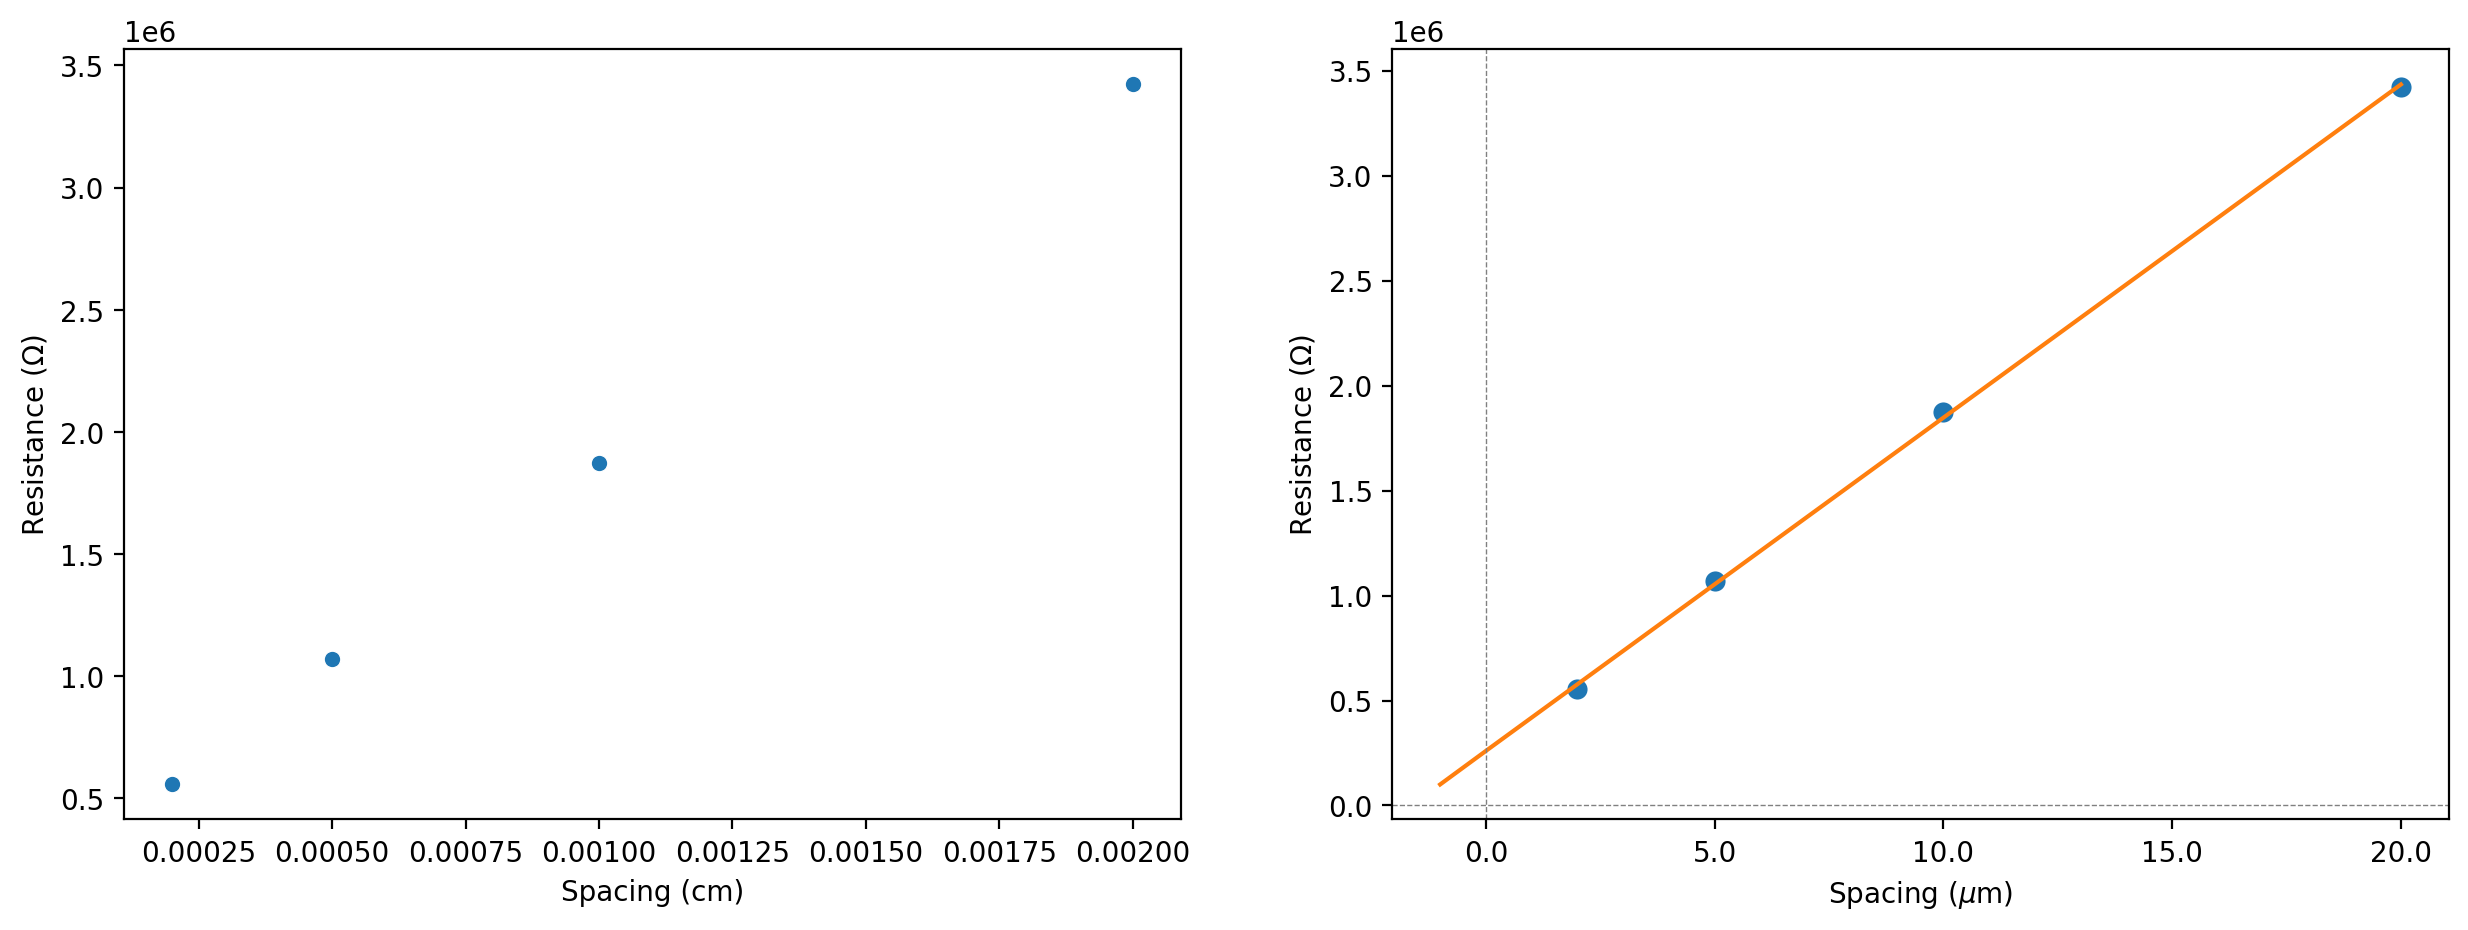

In [91]:
# LMO/C/Pt ext
path = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Contact Resistance\IDEA2_TLM\LMO_C_Pt_ext'
sample = 'LMO 90nm/C 65nm/Pt 100nm ext'
lmo_c_pt2_ext, lmo_c_pt_fit2_ext, lmo_c_pt_fit_vals2_ext, lmo_c_pt_iv_curves2_ext = C_R(path, 90, sample)
print(lmo_c_pt_fit2_ext.fit_report())

c:\Users\lopezb41\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:1240: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
c:\Users\lopezb41\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:1242: RuntimeWarning: divide by zero encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))
c:\Users\lopezb41\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:1248: RuntimeWarning: invalid value encountered in add
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]
c:\Users\lopezb41\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:1240: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
c:\Users\lopezb41\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:1242: RuntimeWarning: divide by zero encountered in divide
  c = 

Contact Resistivity = 2.8385800667687286 Ohm cm2
LMO conductivity = 6.995247224480325e-05 S/cm
[[Model]]
    Model(tlm2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 76
    # data points      = 4
    # variables        = 2
    chi-square         = 106027.479
    reduced chi-square = 53013.7393
    Akaike info crit   = 44.7406368
    Bayesian info crit = 43.5132256
    R-squared          = 0.99974366
[[Variables]]
    r_s:  5.7182e+08 +/- 6453022.55 (1.13%) (init = 1000000)
    N:    60 (fixed)
    w:    0.0005 (fixed)
    L:    0.32 (fixed)
    l_t:  7.0358e-05 +/- 7.1266e-06 (10.13%) (init = 1e-05)
[[Correlations]] (unreported correlations are < 0.100)
    C(r_s, l_t) = -0.841


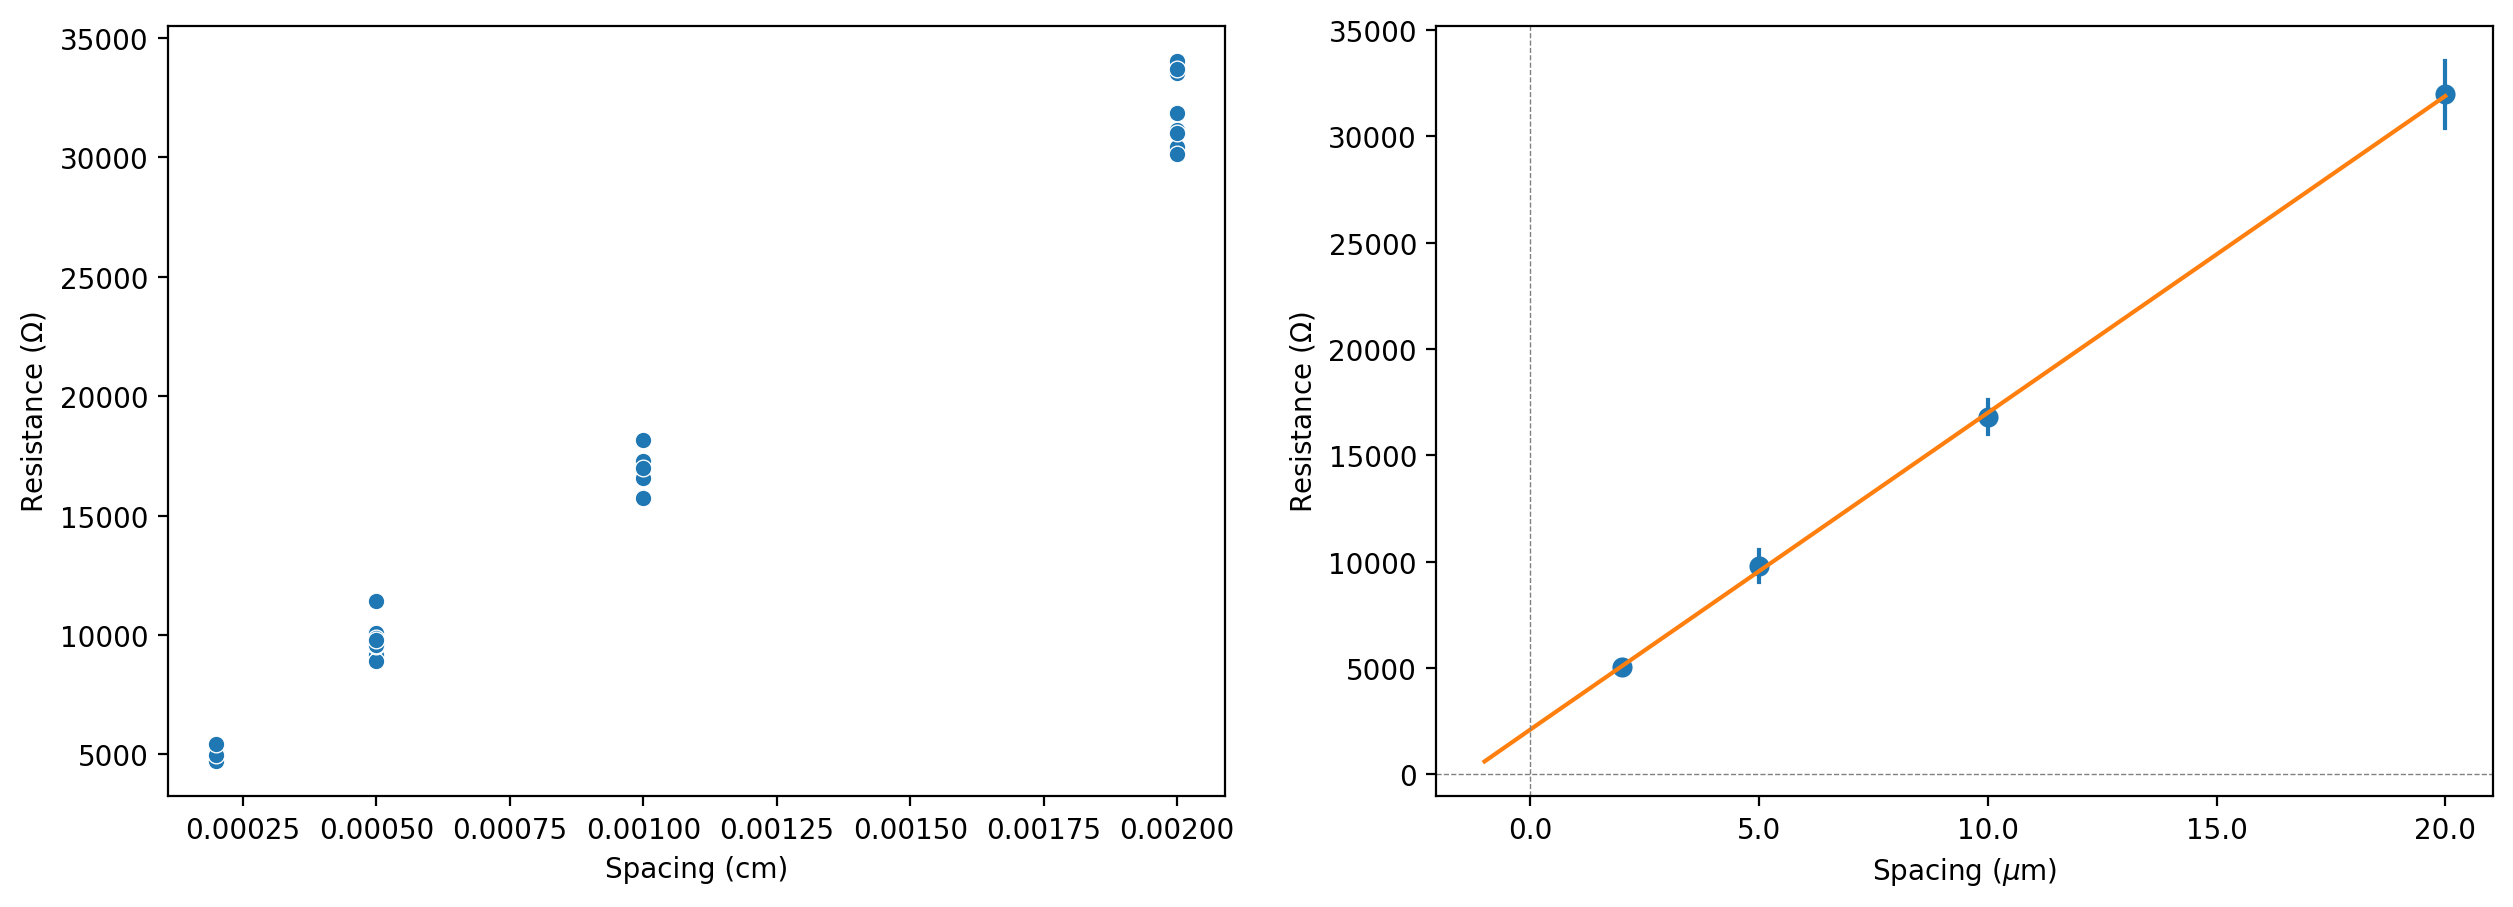

In [92]:
# TI2_03 LMO 8h
path = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Contact Resistance\IDEA2_TLM\LMO8h_Pt'
sample = 'LMO 250nm/Pt 100nm'
lmo8h_pt, lmo8h_pt_fit, lmo8h_pt_fit_vals, lmo8h_pt_iv_curves = C_R(path, 250, sample)
print(lmo8h_pt_fit.fit_report())

c:\Users\lopezb41\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:1240: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
c:\Users\lopezb41\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:1242: RuntimeWarning: divide by zero encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))
c:\Users\lopezb41\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:1248: RuntimeWarning: invalid value encountered in add
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]
c:\Users\lopezb41\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:1240: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
c:\Users\lopezb41\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:1242: RuntimeWarning: divide by zero encountered in divide
  c = 

Contact Resistivity = 1.4819717296519235 Ohm cm2
LMO conductivity = 6.672758969616093e-05 S/cm
[[Model]]
    Model(tlm2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 76
    # data points      = 4
    # variables        = 2
    chi-square         = 33162.5851
    reduced chi-square = 16581.2926
    Akaike info crit   = 40.0915328
    Bayesian info crit = 38.8641215
    R-squared          = 0.99992705
[[Variables]]
    r_s:  5.9945e+08 +/- 3608927.50 (0.60%) (init = 1000000)
    N:    60 (fixed)
    w:    0.0005 (fixed)
    L:    0.32 (fixed)
    l_t:  4.9645e-05 +/- 3.6977e-06 (7.45%) (init = 1e-05)
[[Correlations]] (unreported correlations are < 0.100)
    C(r_s, l_t) = -0.832


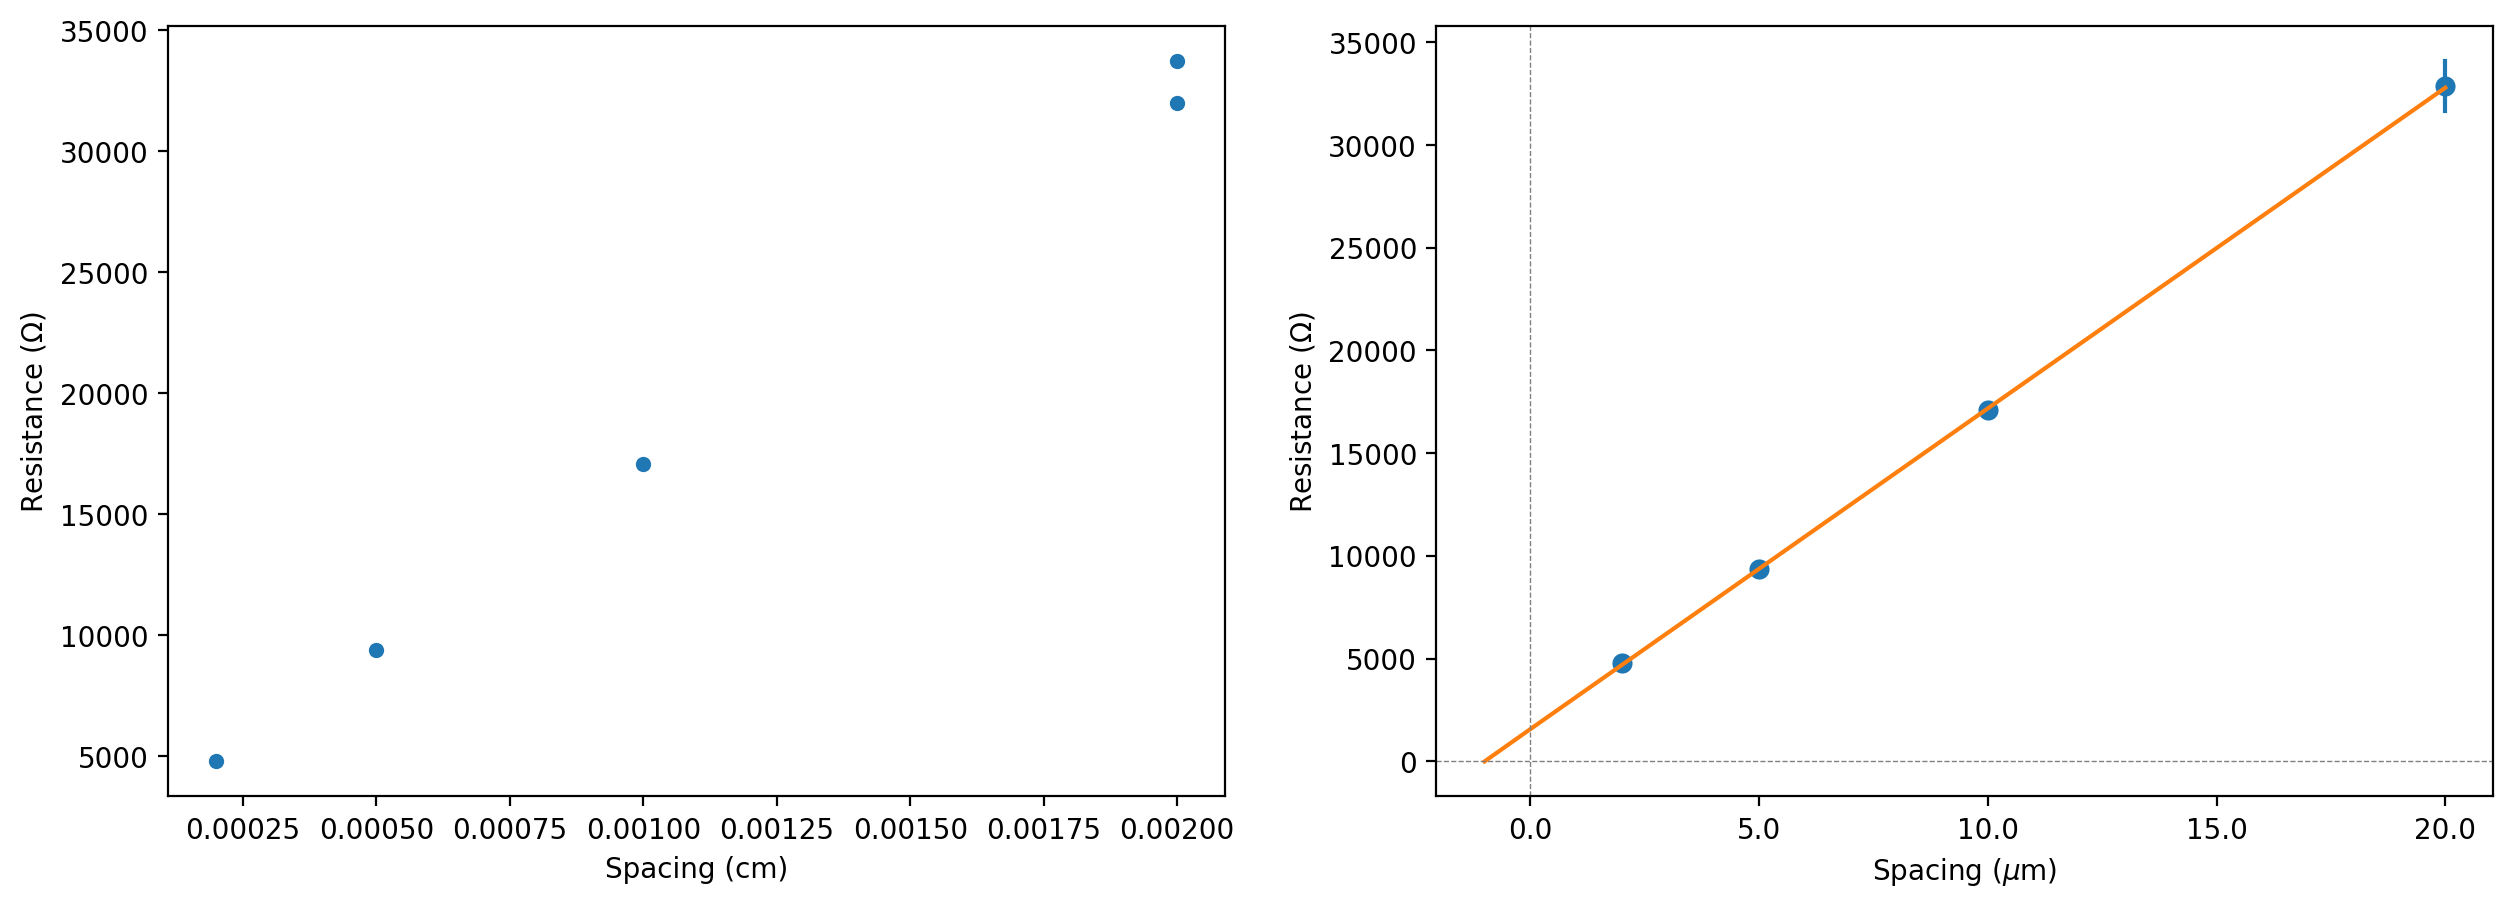

In [93]:
# LMO8h/Pt ext
path = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Contact Resistance\IDEA2_TLM\LMO8h_Pt_ext'
sample = 'LMO 250nm/Pt 100nm ext'
lmo8h_pt_ext, lmo8h_pt_fit_ext, lmo8h_pt_fit_vals_ext, lmo8h_pt_iv_curves_ext = C_R(path, 250, sample)
print(lmo8h_pt_fit_ext.fit_report())

c:\Users\lopezb41\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:1240: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
c:\Users\lopezb41\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:1242: RuntimeWarning: divide by zero encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))
c:\Users\lopezb41\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:1248: RuntimeWarning: invalid value encountered in add
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]
c:\Users\lopezb41\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:1240: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
c:\Users\lopezb41\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:1242: RuntimeWarning: divide by zero encountered in divide
  c = 

Contact Resistivity = 904.3792333790709 Ohm cm2
LMO conductivity = 3.859713383406396e-07 S/cm
[[Model]]
    Model(tlm2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 295
    # data points      = 4
    # variables        = 2
    chi-square         = 1.6968e+12
    reduced chi-square = 8.4840e+11
    Akaike info crit   = 111.093876
    Bayesian info crit = 109.866465
    R-squared          = 0.98407094
[[Variables]]
    r_s:  2.8787e+11 +/- 2.5815e+10 (8.97%) (init = 1000000)
    N:    60 (fixed)
    w:    0.0005 (fixed)
    L:    0.32 (fixed)
    l_t:  5.5969e-05 +/- 5.5548e-05 (99.25%) (init = 1e-05)
[[Correlations]] (unreported correlations are < 0.100)
    C(r_s, l_t) = -0.835


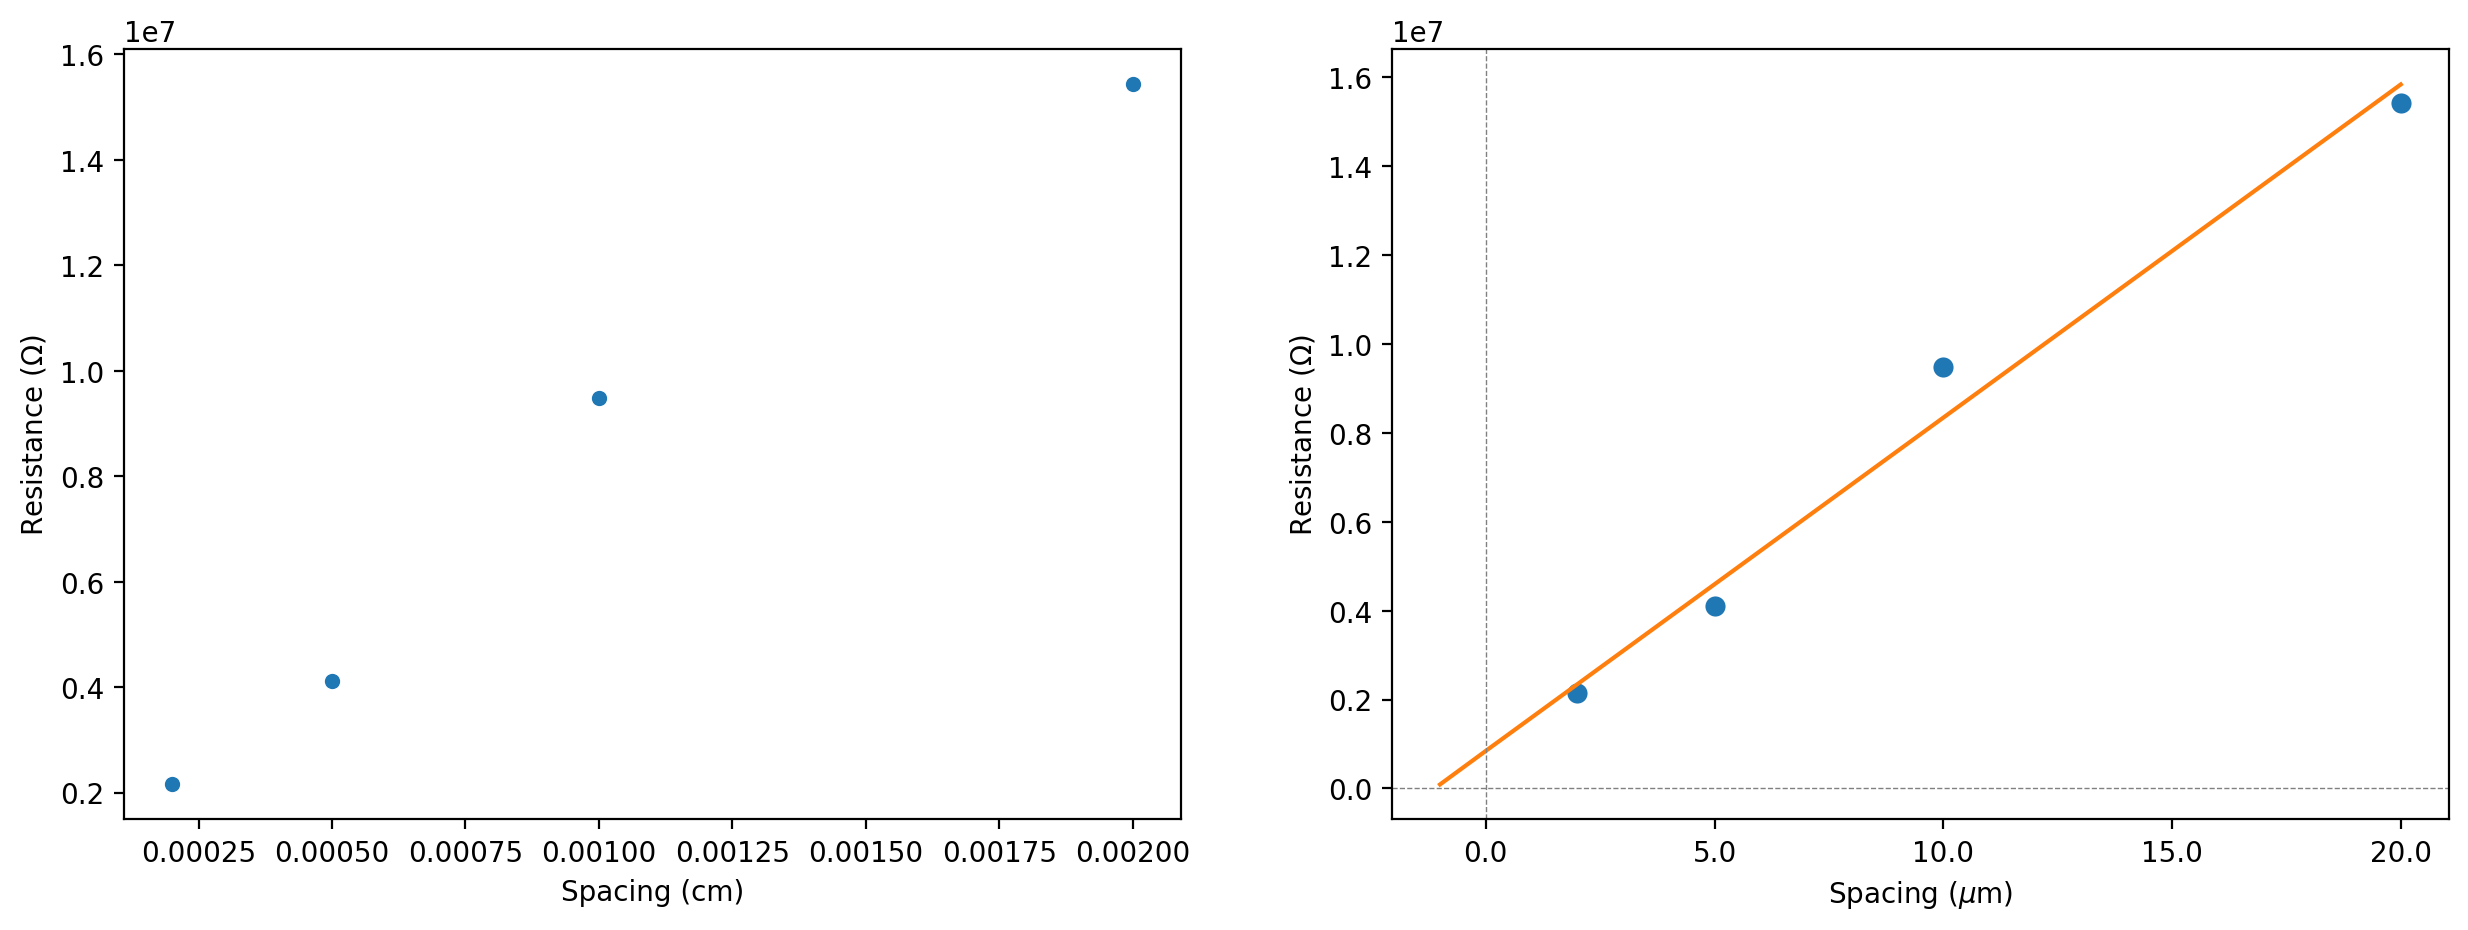

In [94]:
# LMO2h ALD TiO2 4 nm
path = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Contact Resistance\IDEA2_TLM\LMO2h_TiO2_Pt'
sample = 'LMO 90nm/TiO2 4nm/Pt 100nm'
lmo2h_tio2_pt, lmo2h_tio2_pt_fit, lmo2h_tio2_pt_fit_vals, lmo2h_tio2_pt_iv_curves = C_R(path, 90, sample)
print(lmo2h_tio2_pt_fit.fit_report())

,Sheet Resistance,Contact Resistance,Transfer Lenght,Contact Resistivity,Conductivity,Sample,Samples
0,3.199276e+11,221338.900618,0.000026,223.396729,3.473008e-07,LMO 90nm/Pt 100nm,LMO 90nm
1,8.361871e+10,349898.361197,0.000160,2135.961058,1.328783e-06,LMO 90nm/C 65nm/Pt 100nm,LMO 90nm/C 65nm
2,2.878740e+11,422444.848223,0.000056,904.379233,3.859713e-07,LMO 90nm/TiO2 4nm/Pt 100nm,LMO 90 nm/TiO$_2$ 4nm


c:\Users\lopezb41\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\axes\_axes.py:1180: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
c:\Users\lopezb41\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\axes\_axes.py:1181: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


Text(0, 0.5, 'Conductivity $\\sigma$ (S/cm)')

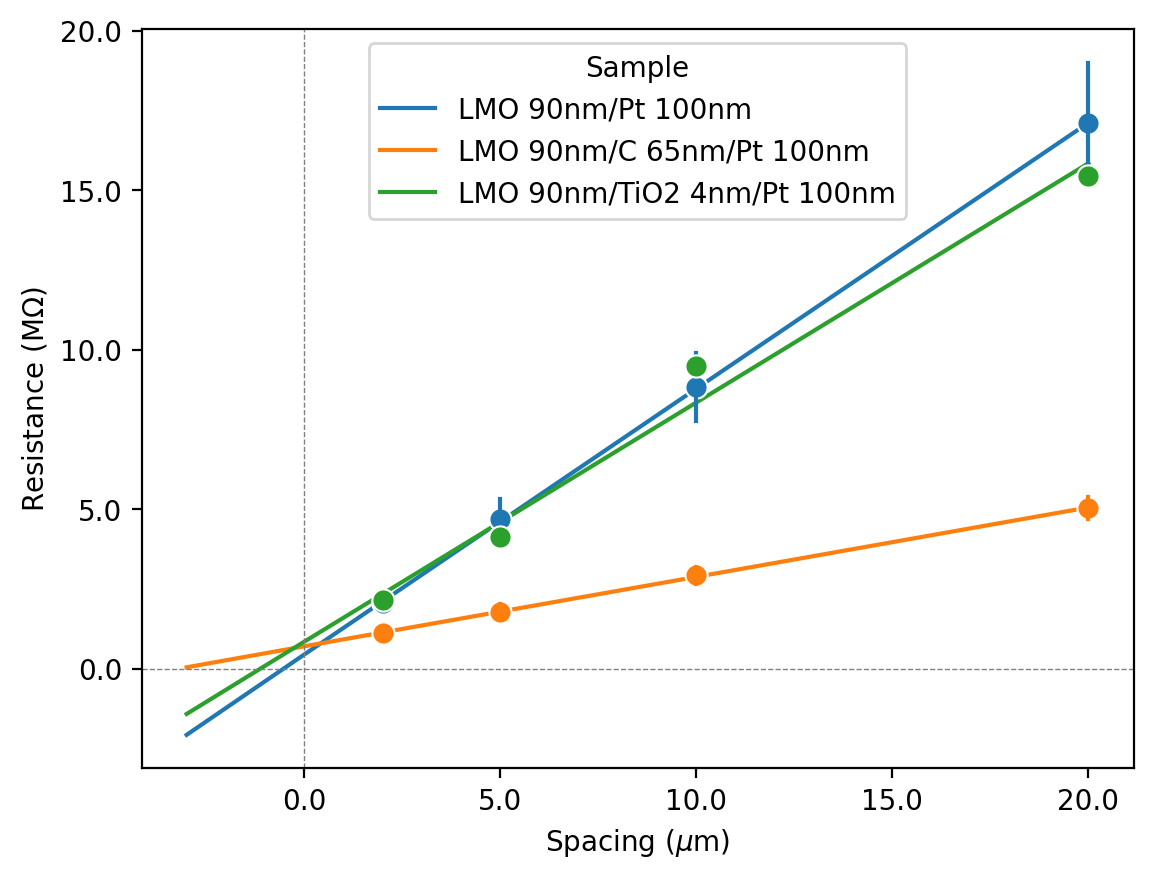

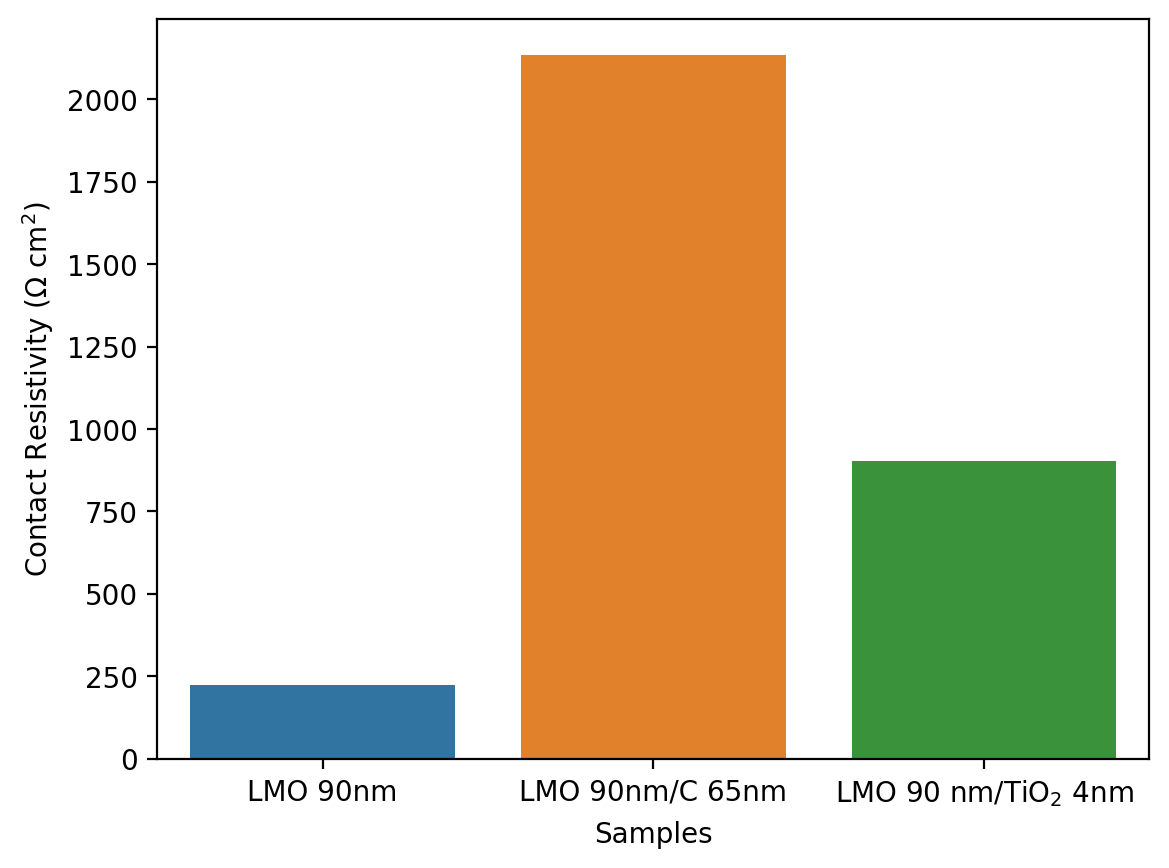

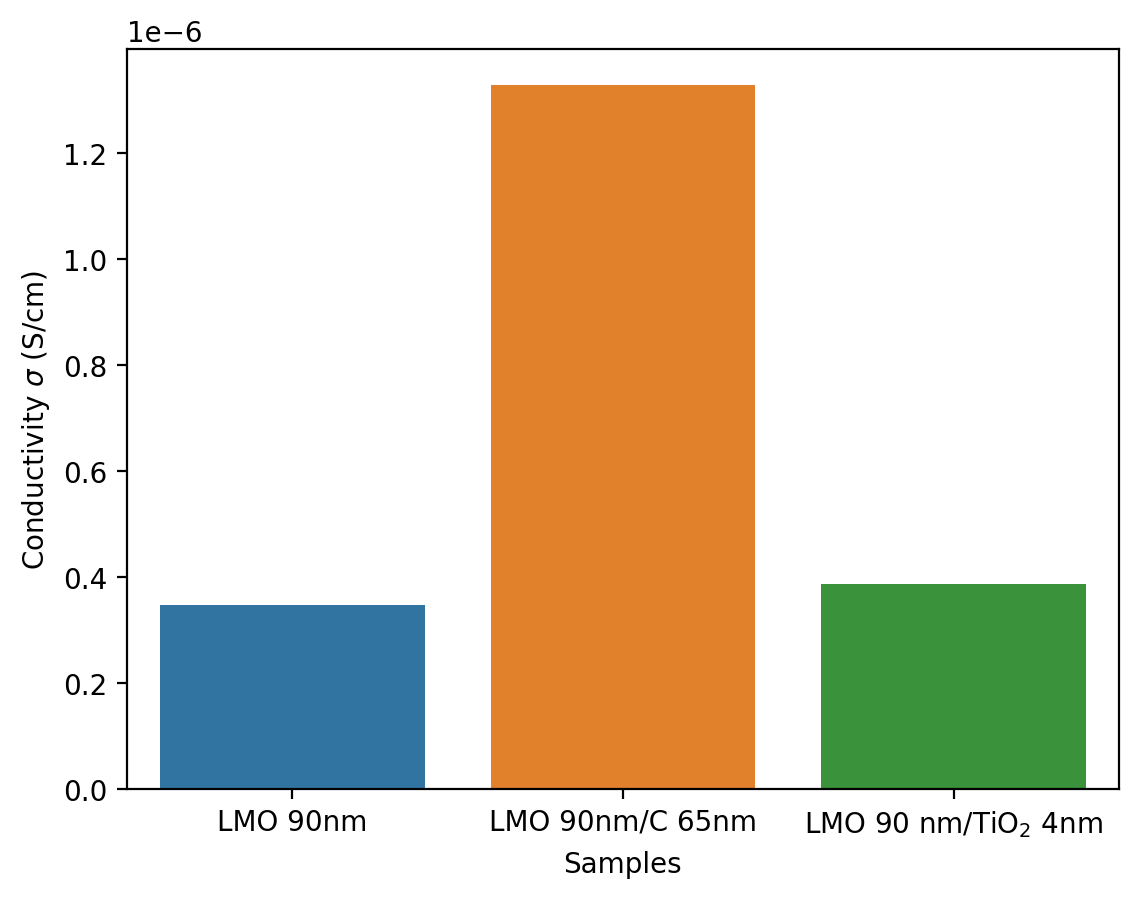

In [95]:
# Compare
cross_zero = np.array([-3, 0, 20]) * 1e-4
    # y_zero = tlm_mod2.eval(tlm_fit2.params, s = cross_zero)

vals = pd.concat([TI2_01, lmo_c_pt,  lmo2h_tio2_pt], ignore_index = True) # lmo8h_pt,
fit = [TI2_01_fit, lmo_c_pt_fit,  lmo2h_tio2_pt_fit] # lmo8h_pt_fit,
fit_val = pd.concat([pd.DataFrame(TI2_01_fit_vals, index = [0]), pd.DataFrame(lmo_c_pt_fit_vals, index = [0]), pd.DataFrame(lmo2h_tio2_pt_fit_vals, index = [0])], ignore_index=True) # pd.DataFrame(lmo8h_pt_fit_vals, index = [0]),
fit_val['Samples'] = ['LMO 90nm', 'LMO 90nm/C 65nm', 'LMO 90 nm/TiO$_2$ 4nm']
display(fit_val)


fig, ax = plt.subplots(dpi = 200)

for i in fit:
    y_zero = tlm_mod2.eval(i.params, s = cross_zero)
    sns.lineplot(x = cross_zero, y = y_zero)


sns.lineplot(data = vals, x = col2[1], y = col2[2], marker='o', markersize = 8, errorbar='sd',err_style='bars', linestyle='', hue = 'Sample')

plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)  # Horizontal zero line
plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)  # Vertical zero line

ax.yaxis.set_major_formatter(formatter)
ax.xaxis.set_major_formatter(formatter_1)

ax.set_xlabel('Spacing ($\mu$m)')
ax.set_ylabel('Resistance (M$\Omega$)')

fig, ax = plt.subplots(dpi = 200)
# ax2 = ax.twinx()
sns.barplot(data = fit_val, x = 'Samples', y = 'Contact Resistivity')
ax.set_ylabel('Contact Resistivity ($\Omega$ cm$^2$)')

fig, ax = plt.subplots(dpi = 200)
sns.barplot(data = fit_val, x = 'Samples', y = 'Conductivity')
ax.set_ylabel('Conductivity $\sigma$ (S/cm)')
# plt.xticks(rotation='vertical')





# TI2_01_fit.params
# vals

<AxesSubplot: xlabel='Potential (V)', ylabel='Norm dI/dV'>

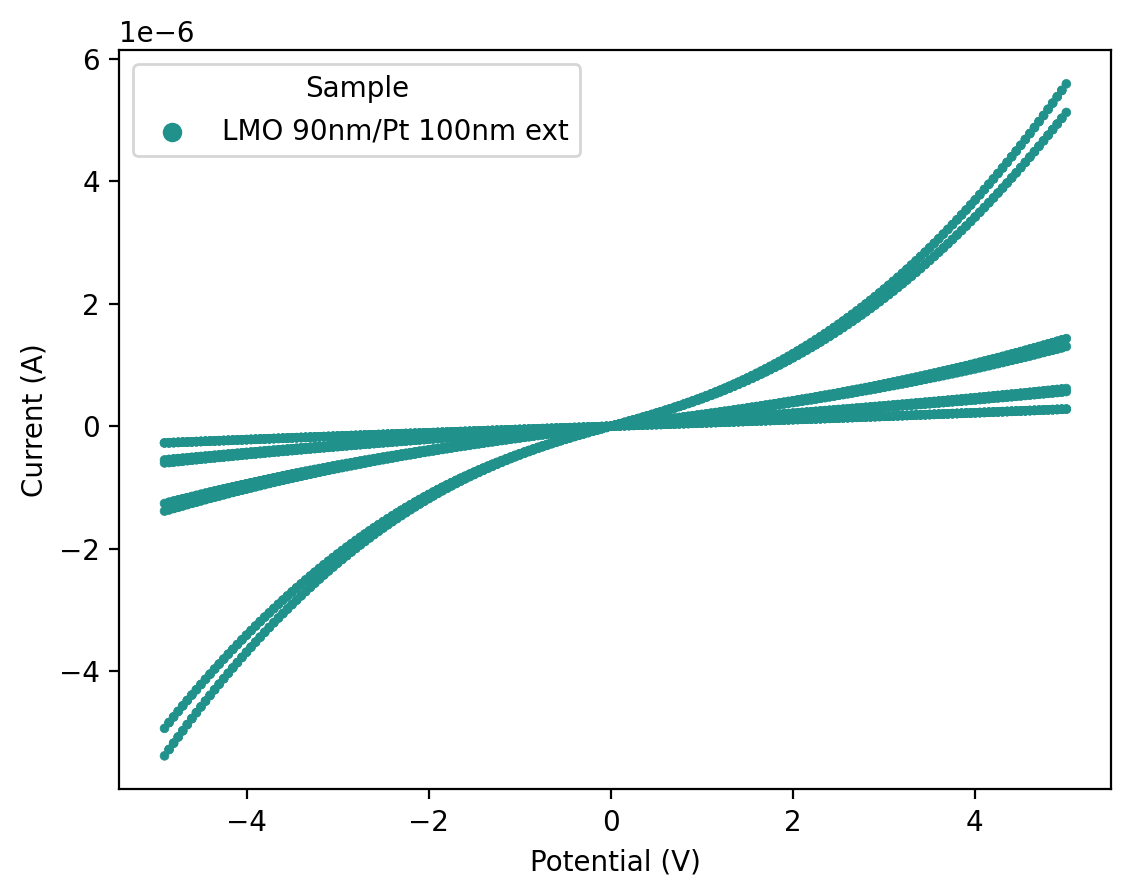

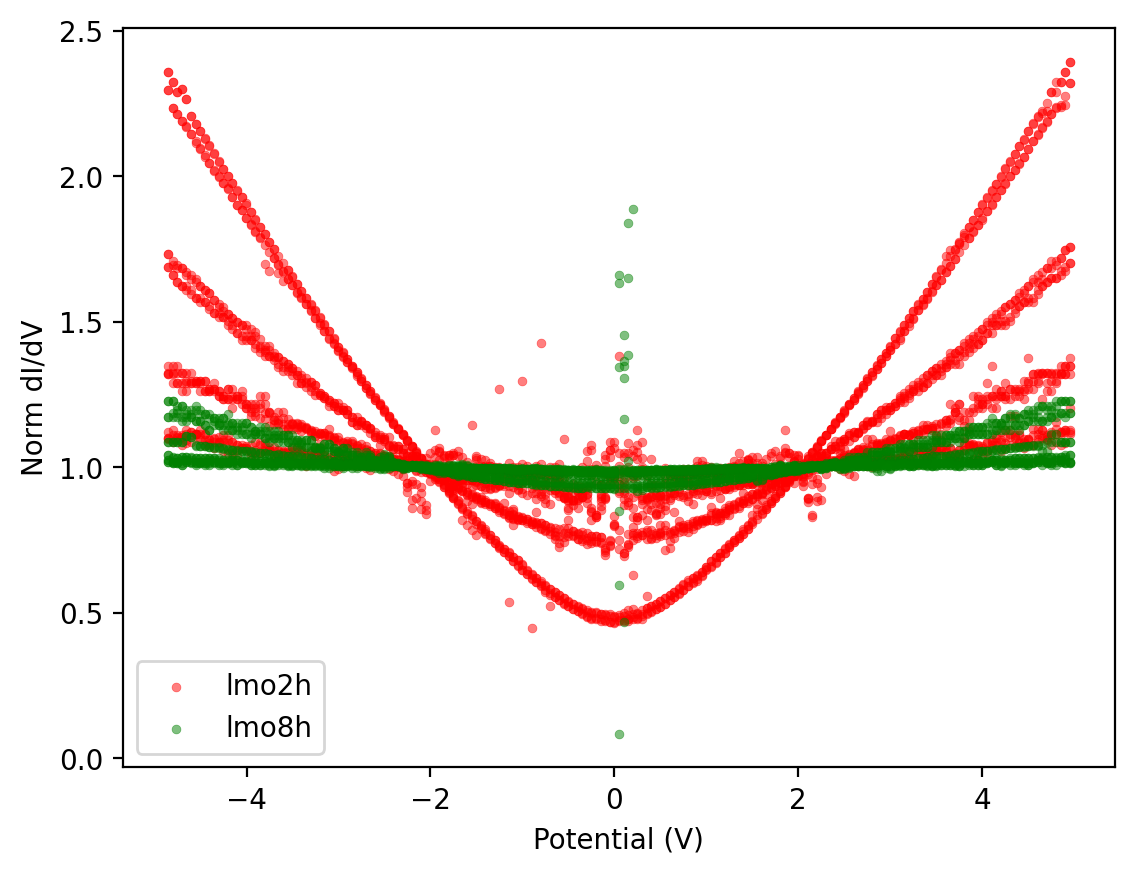

In [110]:
fig, ax = plt.subplots(dpi = 200)
# ax2 = ax.twinx()

# sns.scatterplot(data = lmo_c_pt_iv_curves2_ext, x = 'Potential (V)', y = 'Current (A)', hue = 'Spacing ($\mu$m)', edgecolor = None, s = 5, palette = palette) # lmo2h_pt_iv_curves   Spacing ($\mu$m)TI2_01_iv_curves

# a = pd.concat([lmo2h_pt_iv_curves, TI2_01_iv_curves], ignore_index= True)
# a = pd.concat([lmo_c_pt_iv_curves2_ext, lmo_c_pt_iv_curves2], ignore_index = True)
a = pd.concat([lmo8h_pt_iv_curves_ext], ignore_index=True)
b = pd.concat([lmo2h_pt_iv_curves]) #lmo2h_pt_iv_curves   TI2_01_iv_curves

sns.scatterplot(data = b, x = 'Potential (V)', y = 'Current (A)', hue = 'Sample', style = 'Sample', edgecolor = None, s = 10, palette = palette, ax = ax)
# sns.scatterplot(data = b, x = 'Potential (V)', y = 'Current (A)', hue = 'Sample', style = 'Sample', edgecolor = None, s = 10, palette = palette, ax = ax)
# sns.scatterplot(data = b, x = 'Potential (V)', y = 'Norm dI/dV', edgecolor = None, s = 5, ax = ax, color = 'r', alpha = 0.1)
# sns.scatterplot(data = a, x = 'Potential (V)', y = 'Norm dI/dV', edgecolor = None, s = 5, ax = ax, color = 'g', alpha = 0.1)
# ax.set_ylabel('Current ($\mu$A)')
# ax.yaxis.set_major_formatter(formatter_2)
# ax.legend()

# ax.set_ylim(-1e-4, 5e-4)

fig, ax = plt.subplots(dpi = 200)
sns.scatterplot(data = b, x = 'Potential (V)', y = 'Norm dI/dV', edgecolor = None, s = 10, ax = ax, color = 'r', alpha = 0.5, label = 'lmo2h')
sns.scatterplot(data = a, x = 'Potential (V)', y = 'Norm dI/dV', edgecolor = None, s = 10, ax = ax, color = 'g', alpha = 0.5, label = 'lmo8h')


10.000000000000199


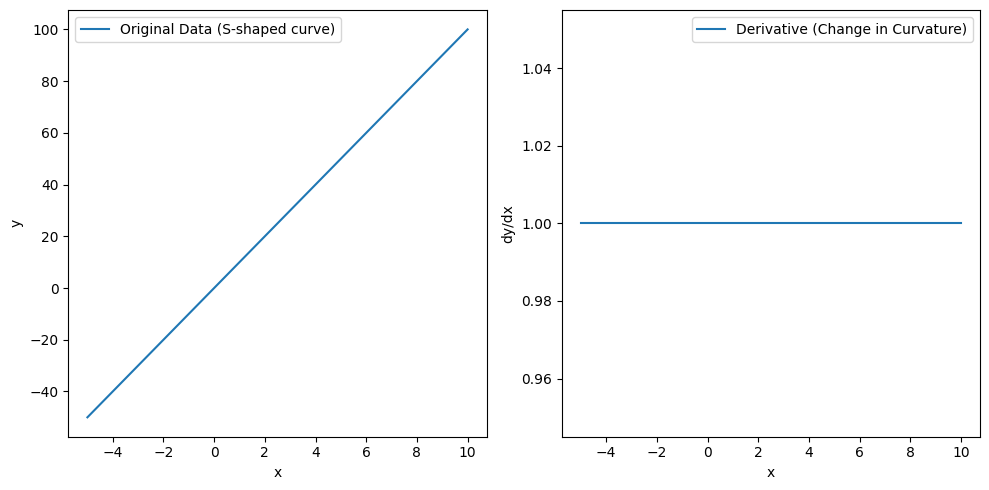

In [97]:
# Assuming you have your data in x and y
# Replace this with your actual data
x = np.array([-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
y = x*10   # S-shaped curve
line_fit = line_mod.fit(y, line_params, x = x)
slope = line_fit.values['m']
# Calculate the derivative using numpy's gradient function
dy_dx = np.gradient(y, x)

print(slope)
# Plot the original data and the derivative
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(x, y, label='Original Data (S-shaped curve)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x, dy_dx / slope , label='Derivative (Change in Curvature)')
plt.xlabel('x')
plt.ylabel('dy/dx')
plt.legend()

plt.tight_layout()
plt.show()

In [98]:
# x = lmo2h_pt_iv_curves['Potential (V)']
# y = lmo2h_pt_iv_curves['Current (A)']
# dy_dx = np.gradient(y, x)
# dy_dx

# # plt.plot(x, y)
# plt.plot(x, dy_dx)